# **ViT5**

# Module 1: Tiền xử lý tổng quát

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 1. Cài đặt thư viện cần thiết
!pip install underthesea rouge-score scikit-learn pandas networkx matplotlib seaborn

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from underthesea import word_tokenize
from rouge_score import rouge_scorer

# 2. Hàm làm sạch văn bản
def clean_text(text):
    if not isinstance(text, str): return ""
    text = re.sub(r'<[^>]+>', '', text)  # Xóa HTML
    text = re.sub(r'http\S+', '', text)  # Xóa URL
    text = re.sub(r'\s+', ' ', text).strip() # Chuẩn hóa khoảng trắng
    return text

# 3. Hàm tách từ
def segment_text(text):
    try:
        return word_tokenize(text, format="text")
    except:
        return text

# 4. Chuẩn bị dữ liệu
df = pd.read_csv("/content/drive/MyDrive/NLP_PROJECT/data/csv_file/original_summary.csv")

print("Đang xử lý dữ liệu...")
df['clean_content'] = df['content'].apply(clean_text)
df['clean_summary'] = df['summary'].apply(clean_text)

# Tạo cột đã tách từ (Dành cho các model cần Word Segmentation)
df['segmented_content'] = df['clean_content'].apply(segment_text)
df['segmented_summary'] = df['clean_summary'].apply(segment_text)

print(f"Đã tải {len(df)} mẫu dữ liệu.")
df.head(2)

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 71.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 978.4/978.4 kB 51.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 49.6 MB/s eta 0:00:00
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=d102d0d0041429f58ead3d63bcacd508f433d82265a604cd59bec9edb5665d48
  Stored in directory: /root/.cache/pip/wheels/85/9d/af/01feefbe7d55ef5468796f0c68225b6788e85d9d0a281e7a70
Successfully built rouge-score
Đang xử lý dữ liệu...
Đã tải 100 mẫu dữ liệu.


,title,content,summary,clean_content,clean_summary,segmented_content,segmented_summary
0,Làng gốm Thanh Hà giành giải 'Điểm du lịch cộn...,"Sáng 27/9, làng gốm Thanh Hà (phường Thanh Hà,...","Làng gốm Thanh Hà được vinh danh là ""Điểm du l...","Sáng 27/9, làng gốm Thanh Hà (phường Thanh Hà,...","Làng gốm Thanh Hà được vinh danh là ""Điểm du l...","Sáng 27/9 , làng gốm_Thanh_Hà ( phường Thanh_H...","Làng gốm Thanh_Hà được vinh_danh là "" Điểm du_..."
1,"""Đọc bã"" cà phê đoán vận mệnh ở Thổ Nhĩ Kỳ","Ở Thổ Nhĩ Kỳ, cà phê đi kèm một chút định mệnh...","Ở Thổ Nhĩ Kỳ, khi uống cạn cà phê, người dân t...","Ở Thổ Nhĩ Kỳ, cà phê đi kèm một chút định mệnh...","Ở Thổ Nhĩ Kỳ, khi uống cạn cà phê, người dân t...","Ở Thổ_Nhĩ_Kỳ , cà_phê đi kèm một_chút định_mện...","Ở Thổ_Nhĩ_Kỳ , khi uống cạn cà_phê , người_dân..."


# Module 2: Mô hình chính

In [ ]:
# Cài đặt thư viện cần thiết
!pip install transformers datasets accelerate rouge_score evaluate underthesea -q

import torch
import pandas as pd
import os
import numpy as np
import evaluate
import nltk
from transformers import (
    AutoTokenizer, AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments,
    Seq2SeqTrainer, DataCollatorForSeq2Seq, EarlyStoppingCallback
)
from datasets import Dataset
from underthesea import word_tokenize, sent_tokenize

try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')
try:
    nltk.data.find('tokenizers/punkt_tab')
except LookupError:
    nltk.download('punkt_tab')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.1 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [ ]:
# Định nghĩa các tham số, chia tập train/test và tạo tokenizer
MODEL_CHECKPOINT = "VietAI/vit5-base"
MAX_INPUT_LENGTH = 1024
MAX_TARGET_LENGTH = 256
BATCH_SIZE = 2
SAVE_MODEL_DIR = "/content/drive/MyDrive/NLP_PROJECT/Model/ViT5_results/ViT5_Final_Weights"

train_size = int(len(df) * 0.8)
train_dataset = Dataset.from_pandas(df.iloc[:train_size])
test_dataset = Dataset.from_pandas(df.iloc[train_size:])
tokenizer = AutoTokenizer.from_pretrained(MODEL_CHECKPOINT)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/820k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

In [ ]:
# Token hóa dữ liệu, tải mô hình, cấu hình các tham số và tải metric ROUGE.
def preprocess_function(examples):
    model_inputs = tokenizer(examples["clean_content"], max_length=MAX_INPUT_LENGTH, truncation=True, padding="max_length")
    labels = tokenizer(text_target=examples["clean_summary"], max_length=MAX_TARGET_LENGTH, truncation=True, padding="max_length")
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenized_train = train_dataset.map(preprocess_function, batched=True)
tokenized_test = test_dataset.map(preprocess_function, batched=True)

model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_CHECKPOINT)
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.config.no_repeat_ngram_size = 3
model.config.early_stopping = True
model.config.length_penalty = 2.0
model.config.num_beams = 2
model.config.max_length = MAX_TARGET_LENGTH

metric = evaluate.load("rouge")

Map:   0%|          | 0/80 [00:00<?, ? examples/s]

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

config.json:   0%|          | 0.00/702 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/904M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/904M [00:00<?, ?B/s]

In [ ]:
# Định nghĩa hàm compute_metrics để tính ROUGE, cấu hình các tham số huấn luyện, và bắt đầu quá trình huấn luyện mô hình ViT5.
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    decoded_preds = [word_tokenize(p, format="text") for p in decoded_preds]
    decoded_labels = [word_tokenize(l, format="text") for l in decoded_labels]

    decoded_preds = ["\n".join(sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(sent_tokenize(label.strip())) for label in decoded_labels]

    result = metric.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=False)
    result = {key: value * 100 for key, value in result.items()}

    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
    result["gen_len"] = np.mean(prediction_lens)
    return {k: round(v, 4) for k, v in result.items()}

args = Seq2SeqTrainingArguments(
    output_dir="/content/vit5-checkpoints",
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="rouge1",
    greater_is_better=True,
    learning_rate=2e-5,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    weight_decay=0.01,
    save_total_limit=1,
    num_train_epochs=20,
    predict_with_generate=True,
    fp16=True,
    report_to="none",
    generation_max_length=256,
    generation_num_beams=2
)

trainer = Seq2SeqTrainer(
    model=model,
    args=args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    data_collator=DataCollatorForSeq2Seq(tokenizer, model=model),
    processing_class=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

print("Training ViT5...")
trainer.train()

Training ViT5...


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Gen Len
1,No log,2.256878,12.996500,3.969000,6.305900,9.393500,50.950000
2,No log,2.076400,76.630800,40.068700,33.674200,68.433900,247.600000
3,No log,2.082249,75.678100,40.628500,34.689000,67.100500,232.900000
4,No log,2.076040,77.779600,41.808700,34.828900,69.439600,247.950000
5,No log,2.154616,76.510700,39.581400,34.041200,67.681500,242.500000
6,No log,2.193366,77.415400,41.185100,34.720100,67.839600,245.050000
7,No log,2.237864,76.541500,40.206100,34.442100,68.595300,242.100000


/usr/local/lib/python3.12/dist-packages/transformers/modeling_utils.py:3918: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 256, 'early_stopping': True, 'num_beams': 2, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(
There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].


TrainOutput(global_step=280, training_loss=1.8149865286690847, metrics={'train_runtime': 1335.5462, 'train_samples_per_second': 1.198, 'train_steps_per_second': 0.599, 'total_flos': 682032837427200.0, 'train_loss': 1.8149865286690847, 'epoch': 7.0})

In [ ]:
# Tạo output
def vit5_predict(text):
    if not isinstance(text, str) or not text.strip(): return ""
    inputs = tokenizer(text, max_length=MAX_INPUT_LENGTH, truncation=True, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model.generate(
            inputs["input_ids"],
            max_length=MAX_TARGET_LENGTH
        )
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

df['predicted_summary'] = df['clean_content'].apply(vit5_predict)

csv_path = "/content/drive/MyDrive/NLP_PROJECT/Model/ViT5_results/Result_ViT5.csv"
os.makedirs(os.path.dirname(csv_path), exist_ok=True)
df[['clean_content', 'clean_summary', 'predicted_summary']].to_csv(csv_path, index=False, encoding='utf-8-sig')

print(f"Đang lưu Model: {SAVE_MODEL_DIR}")
trainer.save_model(SAVE_MODEL_DIR)
tokenizer.save_pretrained(SAVE_MODEL_DIR)

# Module 3: Đánh giá & vẽ biểu đồ

In [ ]:
# Cài đặt thư viện cần thiết
from rouge_score import rouge_scorer
from underthesea import word_tokenize
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from google.colab import drive

In [ ]:
# Thiết lập các biến và tải dữ liệu kết quả từ file CSV hoặc sử dụng DataFrame hiện có
RESULT_FILE_PATH = "/content/drive/MyDrive/NLP_PROJECT/Model/ViT5_results/Result_ViT5.csv"
MODEL_NAME = "ViT5"
col_gen = "predicted_summary"
col_ref = "clean_summary"
col_src = "clean_content"

if not os.path.exists('/content/drive'): drive.mount('/content/drive')

if os.path.exists(RESULT_FILE_PATH):
    df = pd.read_csv(RESULT_FILE_PATH).dropna(subset=[col_gen, col_ref])
else:
    try:
        df = df.copy()
    except NameError:
        raise FileNotFoundError("Không tìm thấy dữ liệu (File CSV hoặc biến df).")

def evaluate_rouge_vietnamese(preds, refs):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=False)
    scores = {'rouge1': [], 'rouge2': [], 'rougeL': []}

    for pred, ref in zip(preds, refs):
        pred = str(pred) if pd.notna(pred) else ""
        ref = str(ref) if pd.notna(ref) else ""

        pred_seg = word_tokenize(pred, format="text")
        ref_seg = word_tokenize(ref, format="text")

        score = scorer.score(ref_seg, pred_seg)
        scores['rouge1'].append(score['rouge1'].fmeasure)
        scores['rouge2'].append(score['rouge2'].fmeasure)
        scores['rougeL'].append(score['rougeL'].fmeasure)

    return {k: np.mean(v) for k, v in scores.items()}

rouge_results = evaluate_rouge_vietnamese(df[col_gen], df[col_ref])
print(f"ROUGE Results for {MODEL_NAME}: {rouge_results}")

df_current = df.copy()
df_current['gen_len'] = df_current[col_gen].apply(lambda x: len(str(x).split()))
df_current['ref_len'] = df_current[col_ref].apply(lambda x: len(str(x).split()))
df_current['src_len'] = df_current[col_src].apply(lambda x: len(str(x).split()))
df_current['length_group'] = df_current['src_len'].apply(lambda x: "< 300" if x < 300 else ("300-600" if x <= 600 else "> 600"))

ROUGE Results for ViT5: {'rouge1': np.float64(0.7787043155612686), 'rouge2': np.float64(0.44931325180300924), 'rougeL': np.float64(0.37276278875579394)}


/tmp/ipython-input-460325864.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=metrics, y=values, palette="viridis")


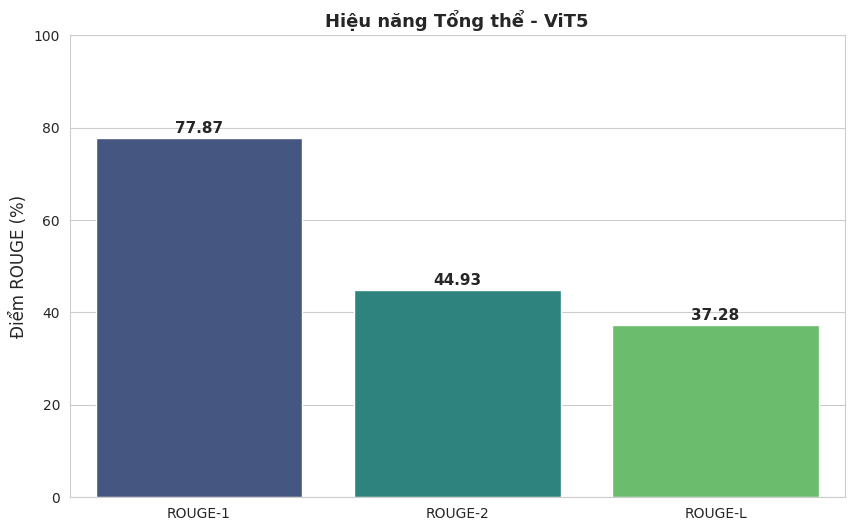

In [ ]:
# BIỂU ĐỒ 1: HIỆU NĂNG TỔNG THỂ
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

metrics = ["ROUGE-1", "ROUGE-2", "ROUGE-L"]
values = [
    rouge_results['rouge1'] * 100,
    rouge_results['rouge2'] * 100,
    rouge_results['rougeL'] * 100
]

ax = sns.barplot(x=metrics, y=values, palette="viridis")

plt.title(f"Hiệu năng Tổng thể - {MODEL_NAME}", fontsize=13, weight='bold')
plt.ylabel("Điểm ROUGE (%)", fontsize=12)
plt.ylim(0, 100)

for i, v in enumerate(values):
    ax.text(i, v + 1, f"{v:.2f}", ha='center', fontsize=11, fontweight='bold')

plt.show()

/tmp/ipython-input-3171642406.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=groups, y=g_scores, palette="magma")


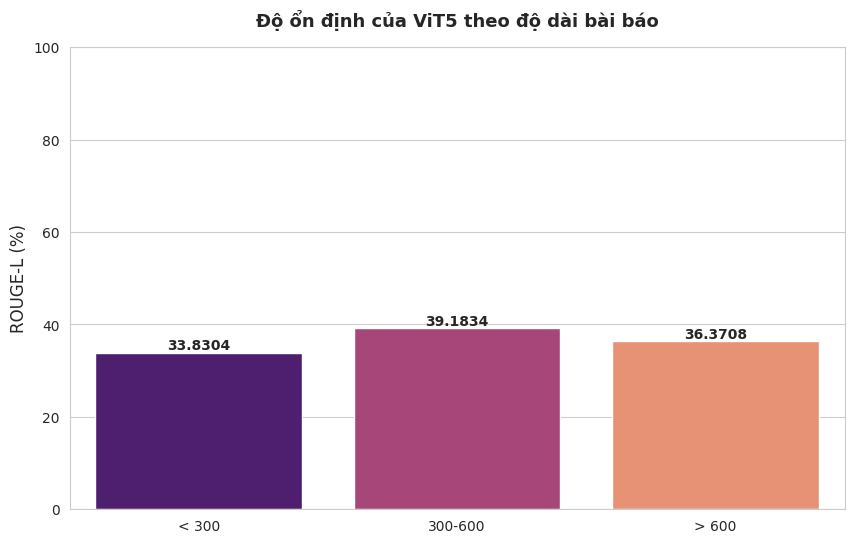

In [ ]:
# BIỂU ĐỒ 2: ROUGE THEO ĐỘ DÀI
plt.figure(figsize=(10, 6))
groups = ["< 300", "300-600", "> 600"]
g_scores = []

for g in groups:
    sub = df_current[df_current["length_group"] == g]
    score = evaluate_rouge_vietnamese(sub[col_gen], sub[col_ref])['rougeL'] if len(sub) > 0 else 0
    g_scores.append(score * 100)

sns.barplot(x=groups, y=g_scores, palette="magma")
plt.title(f"Độ ổn định của {MODEL_NAME} theo độ dài bài báo", fontsize=13, weight='bold', pad=15)
plt.ylabel("ROUGE-L (%)", fontsize=12)
plt.xlabel("")
plt.ylim(0, 100)
for i, v in enumerate(g_scores):
    plt.text(i, v + 0.01, f"{v:.4f}", ha='center', va='bottom', fontweight='bold')
plt.show()


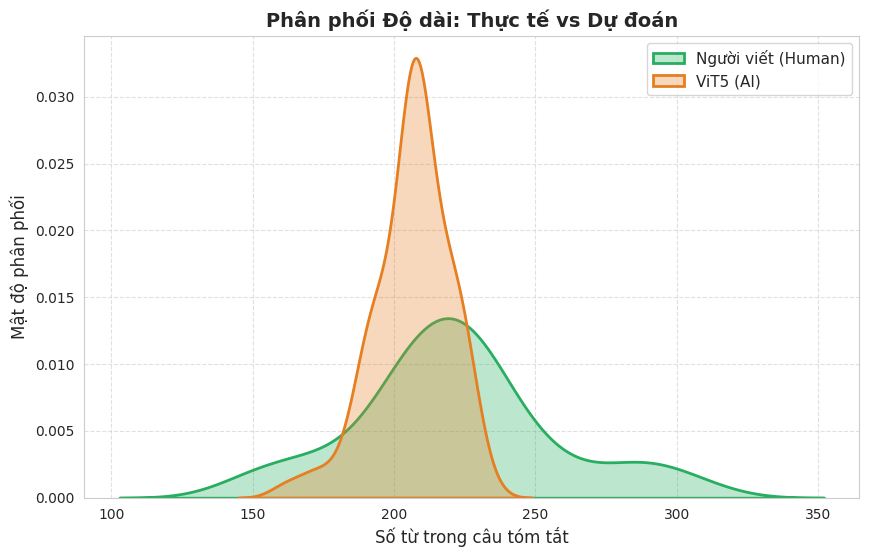

In [ ]:
# BIỂU ĐỒ 3: SO SÁNH PHÂN PHỐI ĐỘ DÀI
plt.figure(figsize=(10, 6))

sns.kdeplot(
    data=df_current, x="ref_len", fill=True,
    label="Người viết (Human)", color="#27ae60", alpha=0.3, linewidth=2
)

sns.kdeplot(
    data=df_current, x="gen_len", fill=True,
    label=f"{MODEL_NAME} (AI)", color="#e67e22", alpha=0.3, linewidth=2
)

plt.title("Phân phối Độ dài: Thực tế vs Dự đoán", fontsize=14, weight='bold')
plt.xlabel("Số từ trong câu tóm tắt", fontsize=12)
plt.ylabel("Mật độ phân phối", fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, linestyle='--', alpha=0.6)

plt.show()

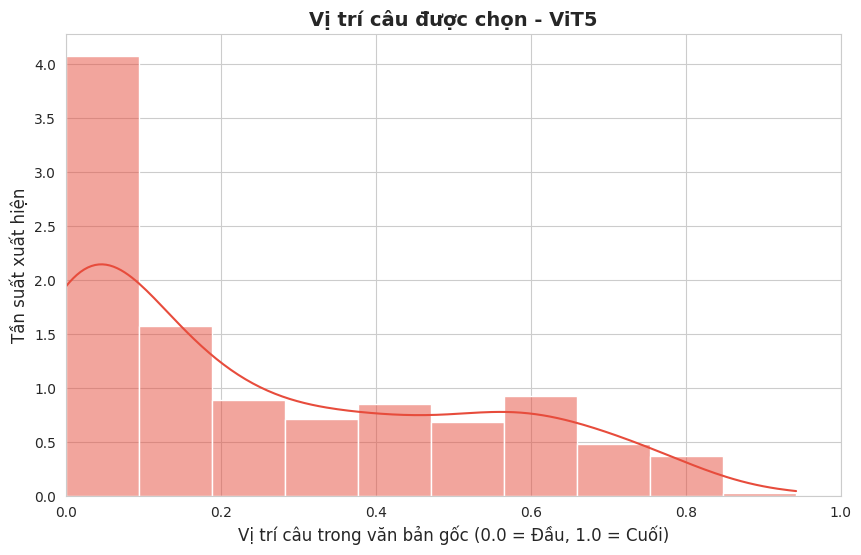

In [ ]:
# BIỂU ĐỒ 4: THIÊN KIẾN VỊ TRÍ (LEAD BIAS)
from difflib import SequenceMatcher

def find_best_match_position(generated_text, original_text):
    gen_sents = str(generated_text).split('.')
    org_sents = str(original_text).split('.')
    if len(org_sents) == 0: return []

    positions = []
    for g_sent in gen_sents:
        if len(g_sent) < 10: continue
        best_ratio = 0
        best_idx = 0
        for i, o_sent in enumerate(org_sents):
            ratio = SequenceMatcher(None, g_sent, o_sent).ratio()
            if ratio > best_ratio:
                best_ratio = ratio
                best_idx = i
        if best_ratio > 0.5:
            positions.append(best_idx / len(org_sents))
    return positions

# Thu thập vị trí
all_positions = []
for idx, row in df_current.iterrows():
    pos = find_best_match_position(row[col_gen], row[col_src])
    all_positions.extend(pos)

plt.figure(figsize=(10, 6))
sns.histplot(all_positions, bins=10, kde=True, color="#e74c3c", stat="density")

plt.title(f"Vị trí câu được chọn - {MODEL_NAME}", fontsize=14, weight='bold')
plt.xlabel("Vị trí câu trong văn bản gốc (0.0 = Đầu, 1.0 = Cuối)", fontsize=12)
plt.ylabel("Tần suất xuất hiện", fontsize=12)
plt.xlim(0, 1)

plt.show()